# Universe Machine

# Notes


TODO:
* Once things are restructured get this ready for PR
* https://docs.google.com/document/d/1kRZUw_nHksmnfgu_u6OtERTrl_w-xgio5t7WndmFQPA/edit
* https://redwoodforest.slack.com/archives/D6UA26L6R/p1515102490000636
* Decide how to drop data in the heatmaps
* Sanity check that halo scatter matches stellar scatter (based off the slope): https://redwoodforest.slack.com/archives/C8G02V8F9/p1516236118000202

New TODO:

# Preamble, Imports, Plotting config

In [4]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.io.fits
import time
import pandas as pd
import scipy

# My libs
import data
import plots as p
import smhm_fit
import fits
import halo_info
import origin_scatter


# when we mess up imports
from importlib import reload

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(linewidth=1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
mpl.rcParams.update({
    "figure.dpi": 200,                    
    "font.size": 12,
    # Ticks
    "ytick.right": True,
    "ytick.direction": "in",
    "ytick.minor.visible": False,
    "xtick.top": True,
    "xtick.direction": "in",
    "xtick.minor.visible": False,
})

# Data

In [7]:
# Note that we have already cut (as of 1 Feb) to centrals with mp > 12
# https://github.com/dr-guangtou/hsc_um2/blob/master/scripts/reduce_um_data_size.py
centrals, satellites = data.load("sfr_catalog_insitu_exsitu_0.712400_final_extended_wpid_wssfr_wv.npz")
print(np.log10(np.min(centrals["mp"])))
print(len(centrals))

11.50023647482564
1124544


### Vis raw data

In [ ]:
d = data_stellar_cut["cen"]["data"]
hm_phm_ratio = d["m"] / d["mp"]

fig, ax = plt.subplots()
ax.hist(hm_phm_ratio, bins=50)
ax.set(
    yscale="log",
    ylabel="Count",
    xlabel="HM / Peak HM",
)

In [ ]:
d.dtype

In [ ]:
d  = data_stellar_cut["cen"]["data"], data_stellar_cut["halo"]["data"]
dh = data_stellar_cut["halo"]["data"]["id" == d["id"]]
sm_hm_ratio = (d["sm"] + d["icl"]) / d["m"]
cen_sm_perc = (d["sm"] + d["icl"]) / (dh["sm"] + dh["icl"])

plt.histogram(sm_hm_ratio, cen_sm_perc, bins=50)

In [ ]:
d = data_stellar_cut["cen"]["data"]
sm_hm_ratio = (d["sm"] + d["icl"]) / d["m"]
fig, ax = plt.subplots()
ax.hist(sm_hm_ratio, bins=50)
ax.set(
    ylabel="Count",
    xlabel="SM / HM",
)
ax.axvline(0.2, color="r")

/home/christopher/.virtualenvs/hsc_um2/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


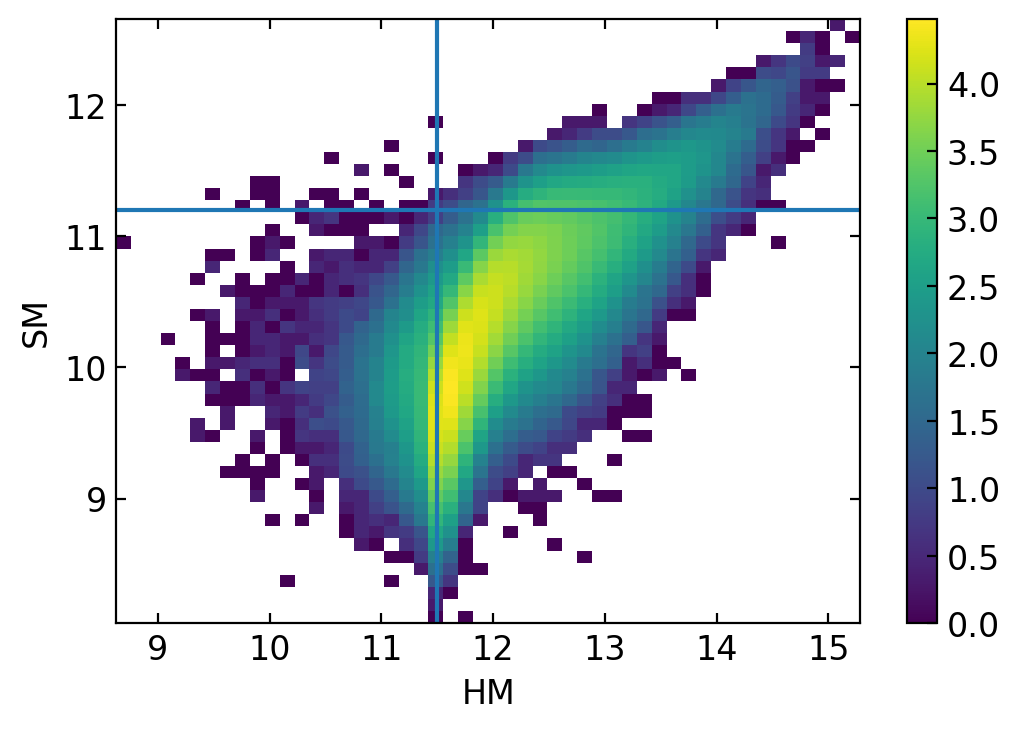

In [152]:
hm = np.log10(centrals["m"])
sm = np.log10(centrals["sm"] + centrals["icl"])
hist, x_edge, y_edge = np.histogram2d(hm, sm, bins=50)

hist = np.log10(hist)
hist = hist.T

fig, ax = plt.subplots()
img = ax.imshow(hist, origin="lower", extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], aspect="auto")
fig.colorbar(img)
ax.set(
    xlabel="HM",
    ylabel="SM",
)
ax.axhline(11.2)
ax.axvline(11.5)
#ax.axhline(12, c="r")
#ax.axvline(14.5, c="r")

/home/christopher/.virtualenvs/hsc_um2/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


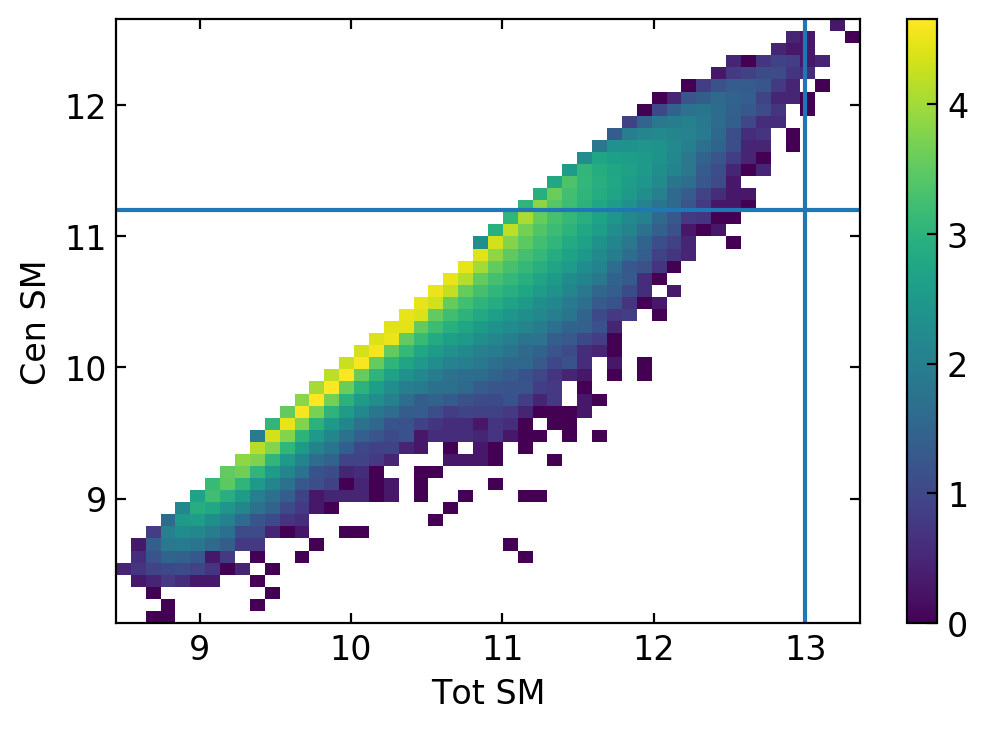

In [149]:
csm = np.log10(data_halo_cut["cen"]["data"]["sm"] + data_halo_cut["cen"]["data"]["icl"])
hsm = np.log10(data_halo_cut["tot"]["data"]["sm"] + data_halo_cut["tot"]["data"]["icl"])
hist, x_edge, y_edge = np.histogram2d(hsm, csm, bins=50)

hist = np.log10(hist)
hist = hist.T

fig, ax = plt.subplots()
img = ax.imshow(hist, origin="lower", extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], aspect="auto")
fig.colorbar(img)
ax.set(
    xlabel="Tot SM",
    ylabel="Cen SM",
)
ax.axhline(11.2)
ax.axvline(13)
#ax.axhline(12, c="r")
#ax.axvline(14.5, c="r")

## Process data

### Data with N sats

In [9]:
data_stellar_cut, data_halo_cut = data.cuts_with_sats(centrals, satellites)

['3.60e+13', '4.42e+11', '9.93e-01', '1.09e-02', '1.95e+00']
['4.36e+12', '7.35e+10', '4.93e-01', '2.27e-01', '2.86e+00']
['3.60e+13', '4.42e+11', '9.93e-01', '1.09e-02', '1.95e+00']
['4.36e+12', '7.35e+10', '4.93e-01', '2.27e-01', '2.86e+00']
['2.20e+13', '3.97e+11', '7.30e-01', '1.53e-01', '1.76e+00']
['4.10e+12', '9.65e+10', '4.33e-01', '2.37e-01', '1.67e+00']
['1.95e+13', '3.58e+11', '7.50e-01', '1.47e-01', '1.66e+00']
['3.07e+12', '6.68e+10', '3.73e-01', '2.31e-01', '1.75e+00']
['1.88e+13', '3.95e+11', '4.78e-01', '2.30e-01', '1.83e+00']
['3.41e+12', '9.04e+10', '3.83e-01', '2.36e-01', '1.38e+00']
['1.52e+13', '3.24e+11', '5.30e-01', '2.12e-01', '1.65e+00']
['2.47e+12', '5.77e+10', '3.11e-01', '2.28e-01', '1.60e+00']
['1.74e+13', '4.13e+11', '7.24e-01', '1.66e-01', '1.17e+00']
['2.34e+12', '6.85e+10', '2.90e-01', '2.28e-01', '1.18e+00']
['1.40e+13', '3.15e+11', '8.20e-01', '1.27e-01', '1.02e+00']
['2.18e+12', '5.21e+10', '2.72e-01', '2.16e-01', '1.65e+00']
['2.92e+13', '6.32e+11',

/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in multiply
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


['4.20e+14', '9.80e+10', '5.27e+00', '4.48e-02', '1.42e+00']


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in multiply
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


['4.20e+14', '9.80e+10', '5.27e+00', '4.48e-02', '1.42e+00']


In [10]:
for key in data_stellar_cut.keys():
    data_stellar_cut[key]["smf"] = fits.build_csmf(data_stellar_cut, key)
    data_stellar_cut[key]["smf_cut"] = fits.build_csmf(data_stellar_cut, key, True)

for key in data_halo_cut.keys():
    data_halo_cut[key]["smf"] = fits.build_csmf(data_halo_cut, key)
    data_halo_cut[key]["smf_cut"] = fits.build_csmf(data_halo_cut, key, True)

data_stellar_cut["cen"]["hmf"] = fits.build_chmf(data_stellar_cut, "cen")

In [11]:
for ds in [data_stellar_cut, data_halo_cut]:
    for key in ds.keys():
        for key2 in ds[key].keys():
            if type(ds[key][key2]) is np.ndarray:
                ds[key][key2].setflags(write=False)
            elif type(ds[key][key2]) is tuple:
                for i in range(len(ds[key][key2])):
                    ds[key][key2][i].setflags(write=False)

In [12]:
richness = {
    "richness": data.create_richness_data(centrals, satellites),
}
richness["rmf"] = fits.build_rmf(richness["richness"])

### Data in a specz/photoz cylinder with N sats

In [14]:
data_stellar_cut_specz, data_halo_cut_obs_specz, _, richness_specz_tmp = data.cylinder_sm_and_richness(centrals, satellites, 15)

for key in data_stellar_cut_specz.keys():
    mass, csmf = fits.build_csmf(data_stellar_cut_specz, key, cut=True)
    data_stellar_cut_specz[key]["smf_cut"] = (mass, csmf) # note that these masses are log!

for key in data_halo_cut_obs_specz.keys():
    mass, csmf = fits.build_csmf(data_halo_cut_obs_specz, key, cut=True)
    data_halo_cut_obs_specz[key]["smf_cut"] = (mass, csmf) # note that these masses are log!

    
#data_stellar_cut_specz["cen"]["hmf"] = fits.build_chmf(data_stellar_cut_specz, "cen")

for ds in [data_stellar_cut_specz, data_halo_cut_obs_specz]:
    for key in ds.keys():
        for key2 in ds[key].keys():
            if type(ds[key][key2]) is np.ndarray:
                ds[key][key2].setflags(write=False)
            elif type(ds[key][key2]) is tuple:
                for i in range(len(ds[key][key2])):
                    ds[key][key2][i].setflags(write=False)
richness_specz = {
    "richness": richness_specz_tmp,
}
richness_specz["rmf"] = fits.build_rmf(richness_specz["richness"])

[(7, 0, 68040000000.0) (10, 1, 58254200000.0) (14, 126113, 62269000000.0) ... (1124541, 126111, 75940000000.0) (1124543, 196873, 54524000000.0) (1124543, 126112, 60354000000.0)]
['3.64e+13', '4.45e+11', '1.01e+00', '3.16e-03', '1.94e+00']
['4.26e+12', '7.34e+10', '4.83e-01', '2.28e-01', '2.71e+00']
[(7, 0, 68040000000.0) (10, 1, 58254200000.0) (14, 126113, 62269000000.0) ... (1124541, 126111, 75940000000.0) (1124543, 196873, 54524000000.0) (1124543, 126112, 60354000000.0)]
['2.07e+13', '3.96e+11', '7.81e-01', '1.45e-01', '1.70e+00']
['2.72e+12', '6.30e+10', '3.39e-01', '2.38e-01', '1.58e+00']
[(7, 0, 68040000000.0) (10, 1, 58254200000.0) (14, 126113, 62269000000.0) ... (1124541, 126111, 75940000000.0) (1124543, 196873, 54524000000.0) (1124543, 126112, 60354000000.0)]
['1.61e+13', '3.74e+11', '3.60e-01', '2.65e-01', '1.93e+00']
['2.09e+12', '5.16e+10', '2.63e-01', '2.35e-01', '1.48e+00']
[(7, 0, 68040000000.0) (10, 1, 58254200000.0) (14, 126113, 62269000000.0) ... (1124541, 126111, 7594

In [15]:
data_stellar_cut_photoz, data_halo_cut_obs_photoz, _, richness_photoz_tmp = data.cylinder_sm_and_richness(centrals, satellites, 50)
                                                                                                                                   
for key in data_stellar_cut_photoz.keys():                                                                                         
    mass, csmf = fits.build_csmf(data_stellar_cut_photoz, key, cut=True)                                                           
    data_stellar_cut_photoz[key]["smf_cut"] = (mass, csmf) # note that these masses are log!                                       
                                                                                                                                   
for key in data_halo_cut_obs_photoz.keys():                                                                                        
    mass, csmf = fits.build_csmf(data_halo_cut_obs_photoz, key, cut=True)                                                          
    data_halo_cut_obs_photoz[key]["smf_cut"] = (mass, csmf) # note that these masses are log!                                      
                                                                                                                                   
                                                                                                                                   
#data_stellar_cut_photoz["cen"]["hmf"] = fits.build_chmf(data_stellar_cut_photoz, "cen")                                           
                                                                                                                                   
for ds in [data_stellar_cut_photoz, data_halo_cut_obs_photoz]:                                              
    for key in ds.keys():                                                                                                          
        for key2 in ds[key].keys():                                                                                                
            if type(ds[key][key2]) is np.ndarray:                                                                                  
                ds[key][key2].setflags(write=False)                                                                                
            elif type(ds[key][key2]) is tuple:                                                                                     
                for i in range(len(ds[key][key2])):                                                                                
                    ds[key][key2][i].setflags(write=False)                                                                         
richness_photoz = {                                                                                                                
    "richness": richness_photoz_tmp,                                                                                               
}                                                                                                                                  
richness_photoz["rmf"] = fits.build_rmf(richness_photoz["richness"])                                                               

[(7, 0, 68040000000.0) (10, 1, 58254200000.0) (14, 126113, 62269000000.0) ... (1124541, 126111, 75940000000.0) (1124543, 196873, 54524000000.0) (1124543, 126112, 60354000000.0)]
['3.60e+13', '4.43e+11', '1.02e+00', '7.85e-07', '1.94e+00']
['4.23e+12', '7.38e+10', '4.79e-01', '2.29e-01', '2.64e+00']
[(7, 0, 68040000000.0) (10, 1, 58254200000.0) (14, 126113, 62269000000.0) ... (1124541, 126111, 75940000000.0) (1124543, 196873, 54524000000.0) (1124543, 126112, 60354000000.0)]
['2.21e+13', '4.27e+11', '8.15e-01', '1.39e-01', '1.73e+00']
['2.77e+12', '6.48e+10', '3.44e-01', '2.37e-01', '1.55e+00']
[(7, 0, 68040000000.0) (10, 1, 58254200000.0) (14, 126113, 62269000000.0) ... (1124541, 126111, 75940000000.0) (1124543, 196873, 54524000000.0) (1124543, 126112, 60354000000.0)]
['1.68e+13', '4.07e+11', '4.88e-01', '2.42e-01', '1.86e+00']
['2.10e+12', '5.27e+10', '2.66e-01', '2.35e-01', '1.44e+00']
[(7, 0, 68040000000.0) (10, 1, 58254200000.0) (14, 126113, 62269000000.0) ... (1124541, 126111, 7594

### Sanity checks/exploration

135819
196874
176063


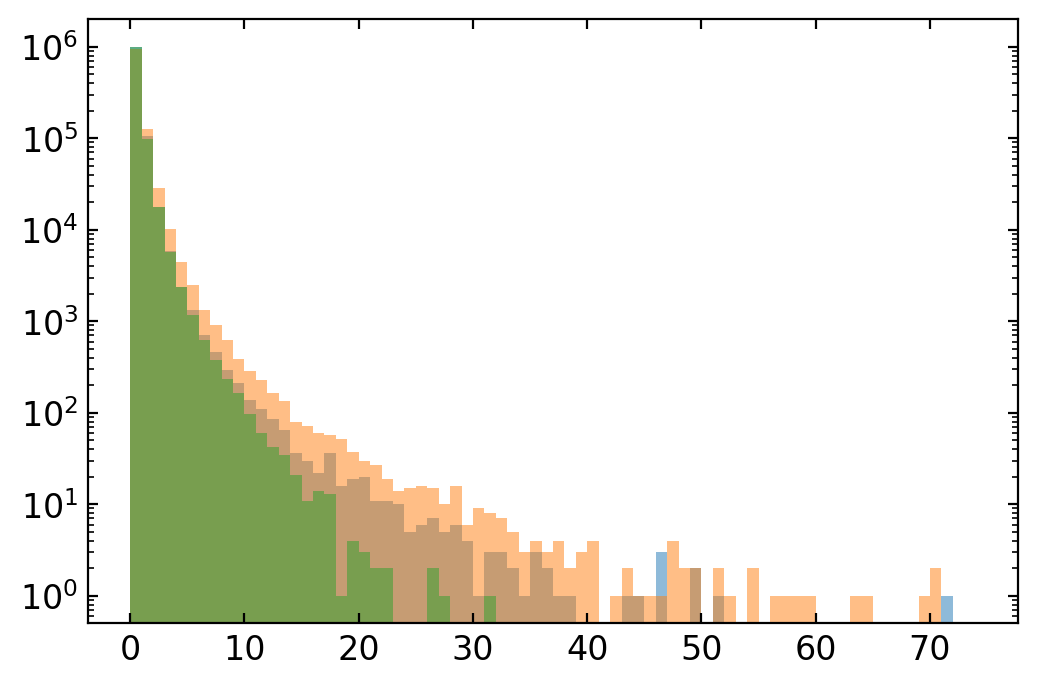

In [31]:
r = richness["richness"]["richness"]
r1 = richness["richness"]["photoz_richness"]
r2 = richness["richness"]["specz_richness"]


x = plt.hist(r, bins=np.arange(75), alpha=0.5)
x = plt.hist(r1, bins=np.arange(75), alpha=0.5)
x = plt.hist(r2, bins=np.arange(75), alpha=0.5)


plt.yscale('log', nonposy='clip')

print(np.count_nonzero(r >= 1))
print(np.sum(r))
print(np.count_nonzero(r1 >= 1))

In [ ]:
# https://arxiv.org/pdf/1410.1193.pdf says that 6.2% of richness comes from non cluster galaxies
# With an error of 52 we get 24%
print(np.sum(r))
print(np.sum(r1))
print(np.average(r1[r >= 20]/r[r >= 20]))

In [ ]:
print(data_stellar_cut.keys())
for key in data_stellar_cut.keys():
    print(key)
    print(key, len(data_stellar_cut[key]["data"]), len(data_halo_cut[key]["data"]))

In [ ]:
print(data_halo_cut.keys())
print(data_halo_cut["cen"].keys())
print(data_stellar_cut["cen"].keys())
print(len(data_stellar_cut["cen"]["data_cut"]))

### Sanity check these fits

They all kinda look like power laws? A little too much like power laws.

Also some analysis of these fits in the paper

If we are going for a power law, we have
```
log(HM) = log(M1) + B log(SM / sm0)
HM = M1 * (SM/sm0)^B = M1 * SM^B / (sm0)^B = M1/sm0^B * SM^B
log(HM) = log(M1/sm0*B) + B*log(SM)
log(HM) = log(M1)-log(sm0) - log(B) + B*SM
```

In [ ]:
print("m1, sm0, beta, delta, gamma")
for key in data_halo_cut.keys():
    f = data_halo_cut[key]["fit"]
    print("{}, {:2f}, {:2f}, {:2f}, {:2f}, {:2f}".format(key, np.log10(f[0]), np.log10(f[1]), f[2], f[3], f[4]))

In [ ]:
def get_power_law_coeffs(m1, sm0, beta, delta, gamma):
    if np.abs(gamma) > 1e-9 or np.abs(delta) > 1e-9:
        print("not a power law!")
        return
    # y = az^(b)
    a = np.log10(m1) - np.log10(sm0) - np.log10(beta)
    b = beta
    print("HM = {} * SM ^ {}".format(a, b))
    print("SM = {} * HM ^ {}".format(1/(a**(1/b)), 1/b))
for key in data_halo_cut.keys():
    print(key)
    get_power_law_coeffs(*data_halo_cut[key]["fit"])
for key in data_stellar_cut.keys():
    print(key)
    get_power_law_coeffs(*data_stellar_cut[key]["fit"])

In [ ]:
for key in data_halo_cut.keys():
    print(data_halo_cut[key]["fit"])

#### Plots

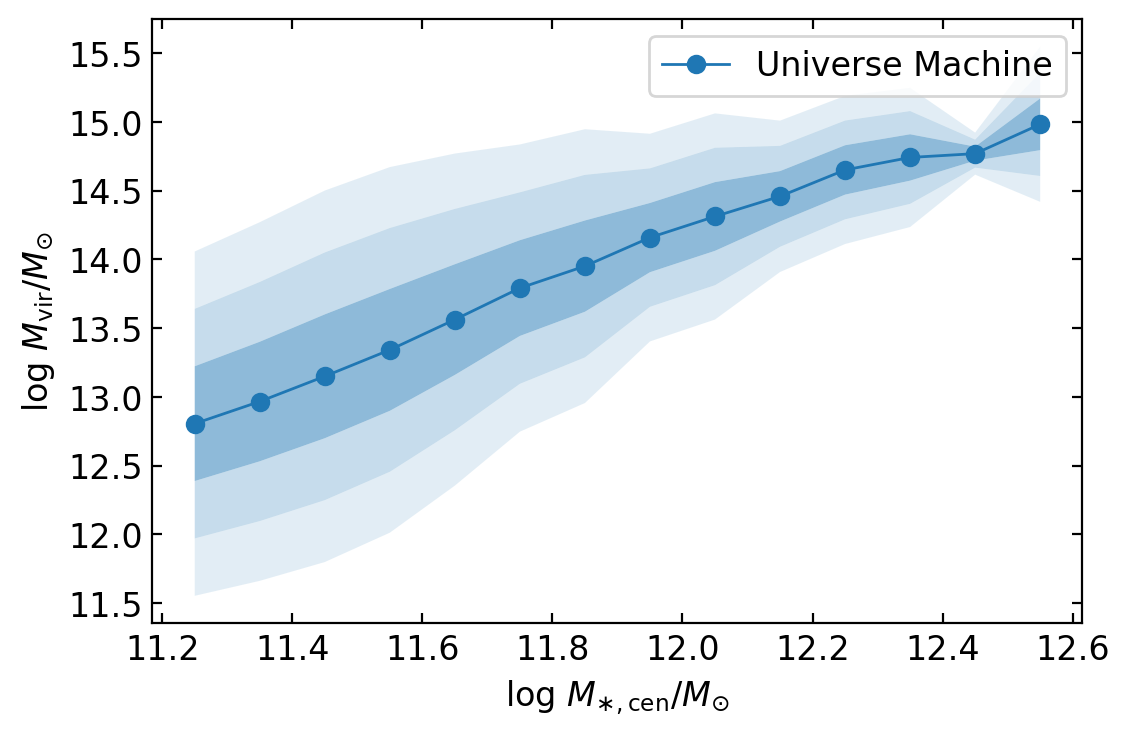

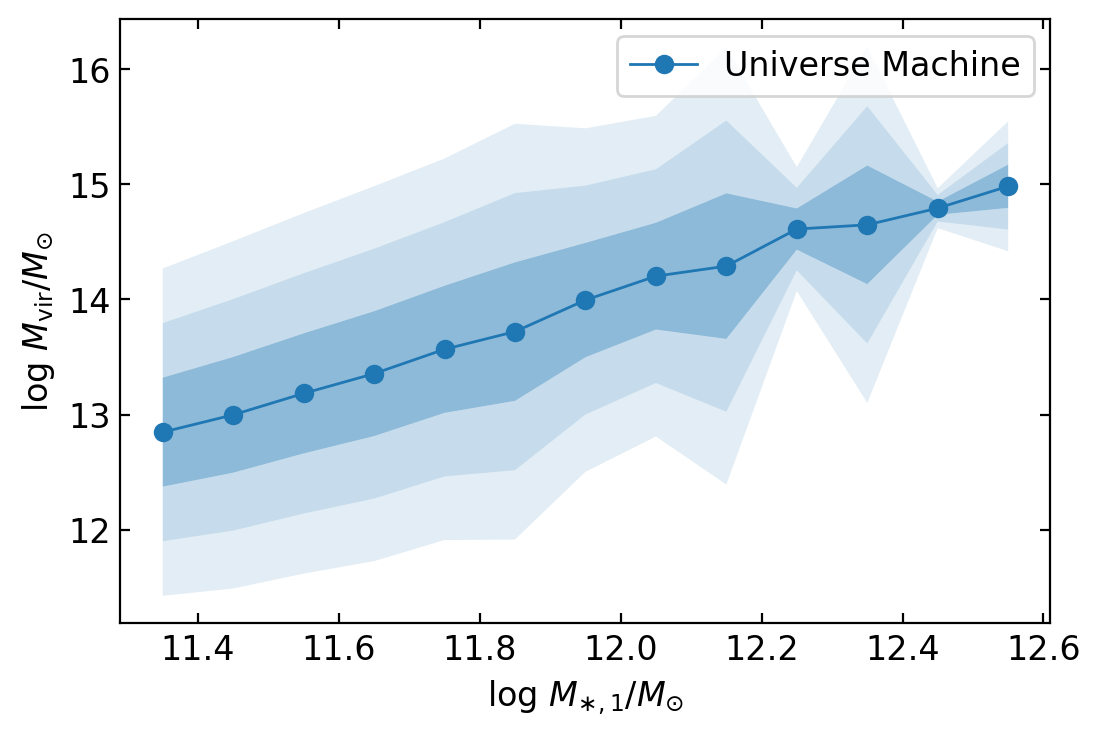

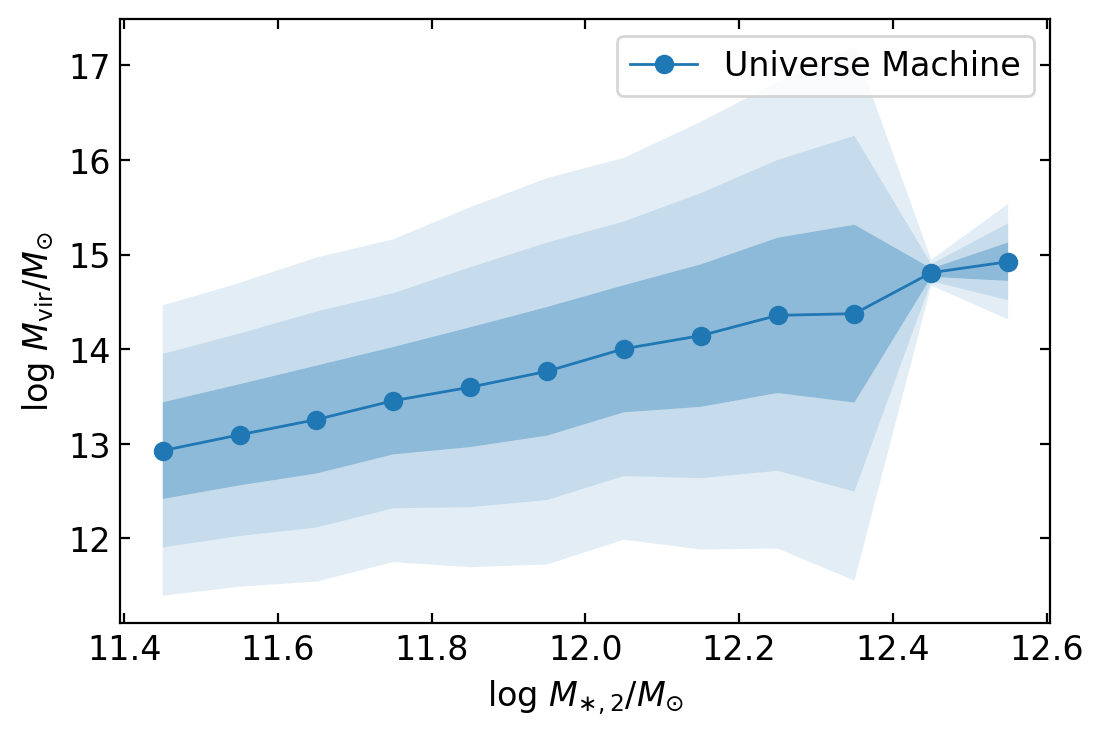

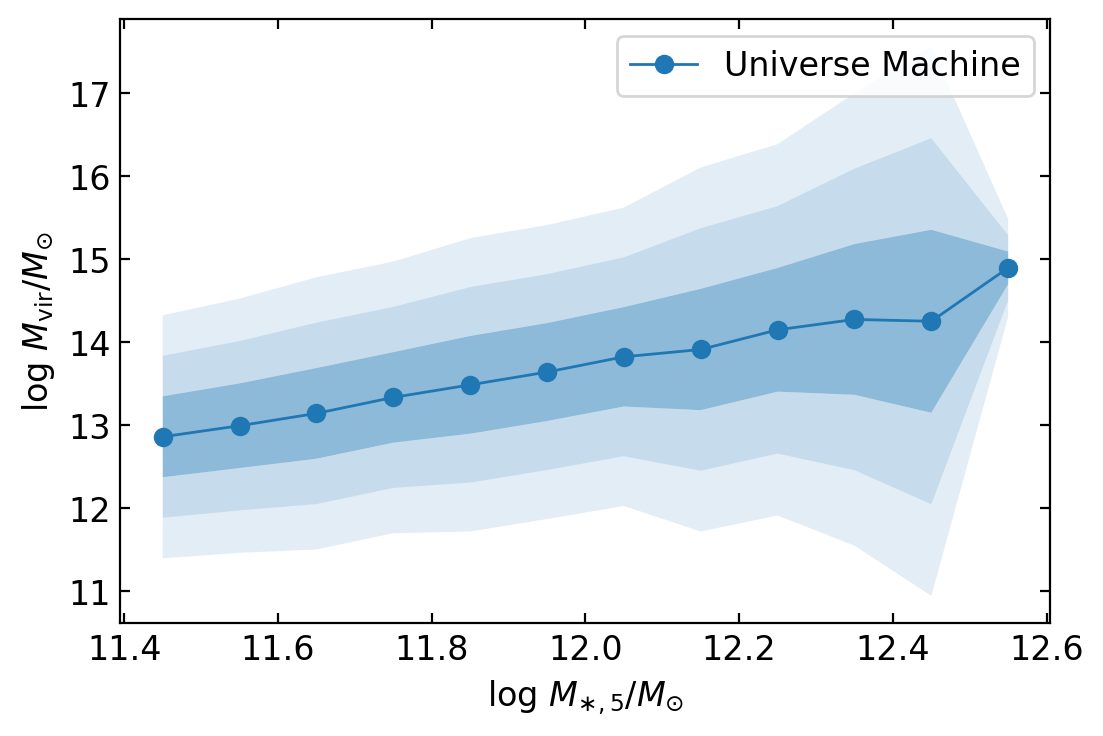

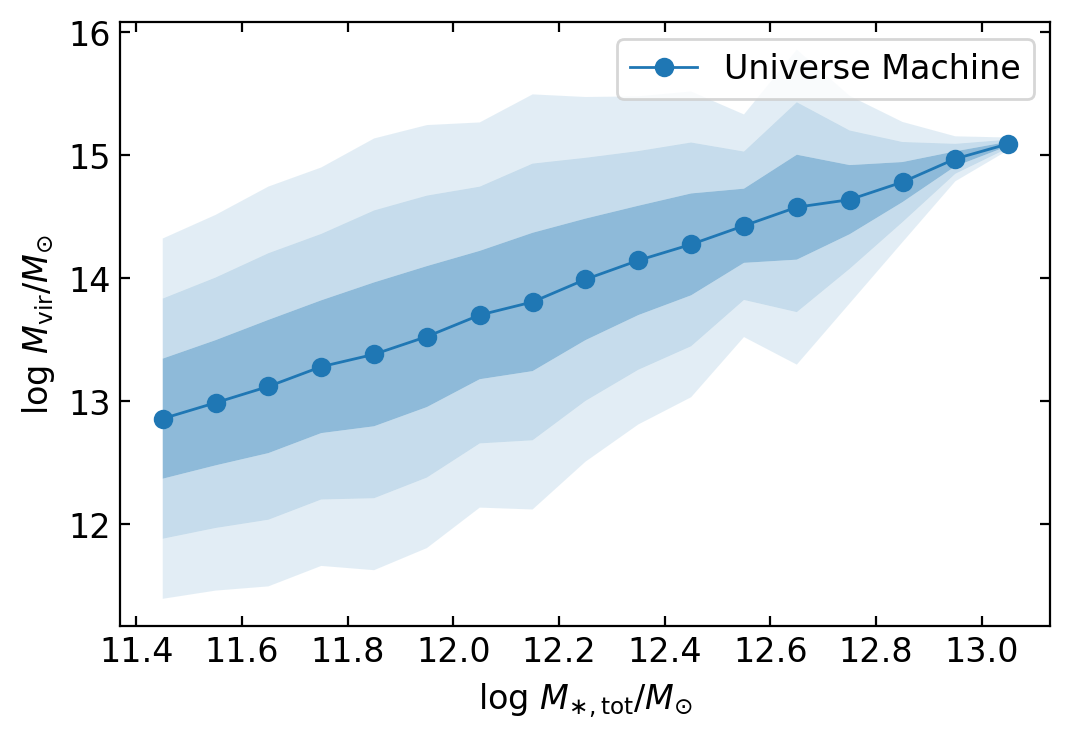

In [36]:
for key in ["cen", 1, 2, 5, "tot"]: #data_stellar_cut.keys():
    _, ax = plt.subplots()
    p.sm_hm.hm_at_fixed_sm(data_stellar_cut_obs[key]["data"], key, ax =ax)

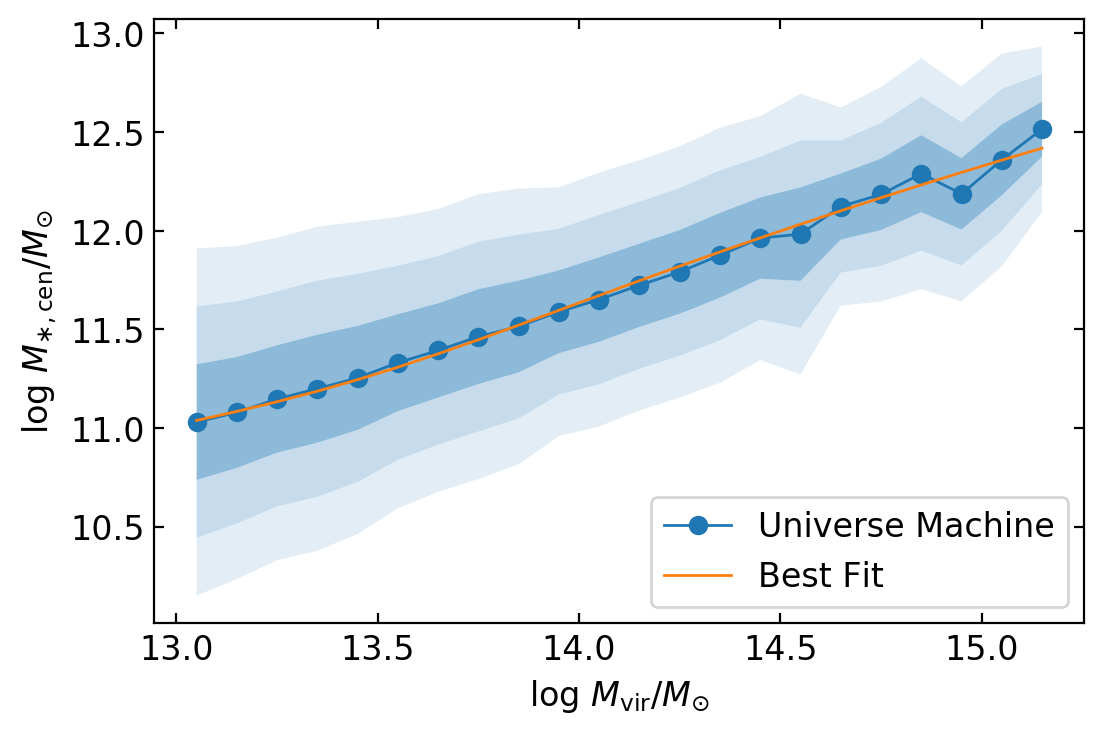

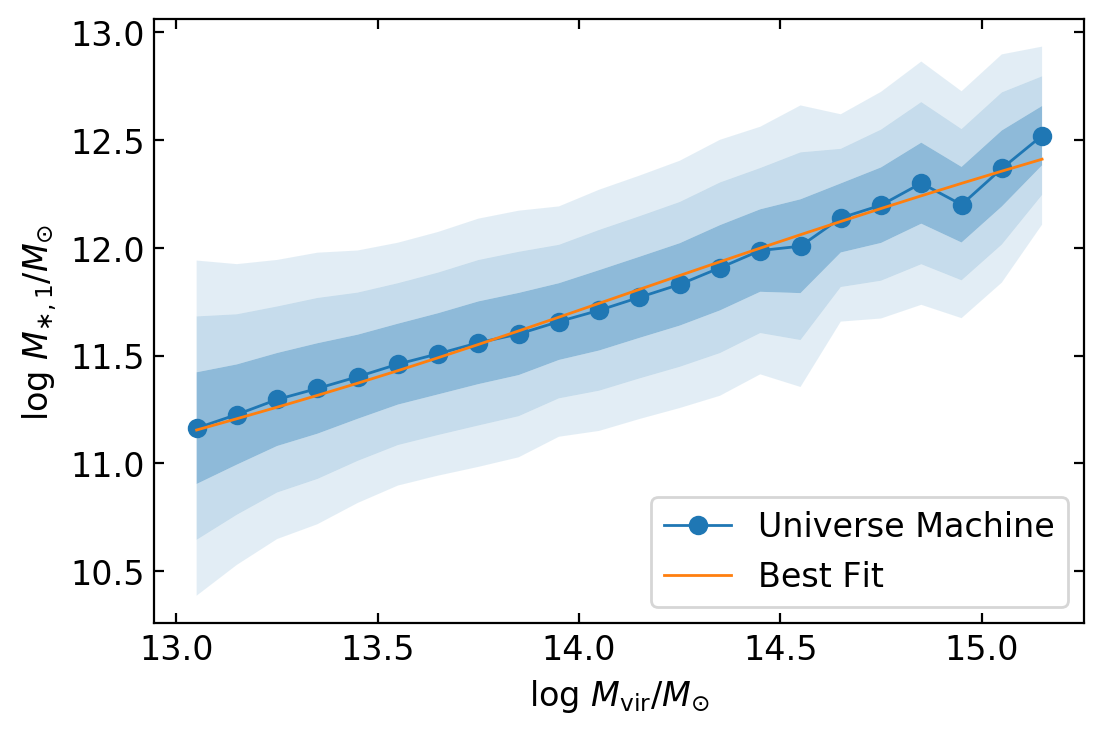

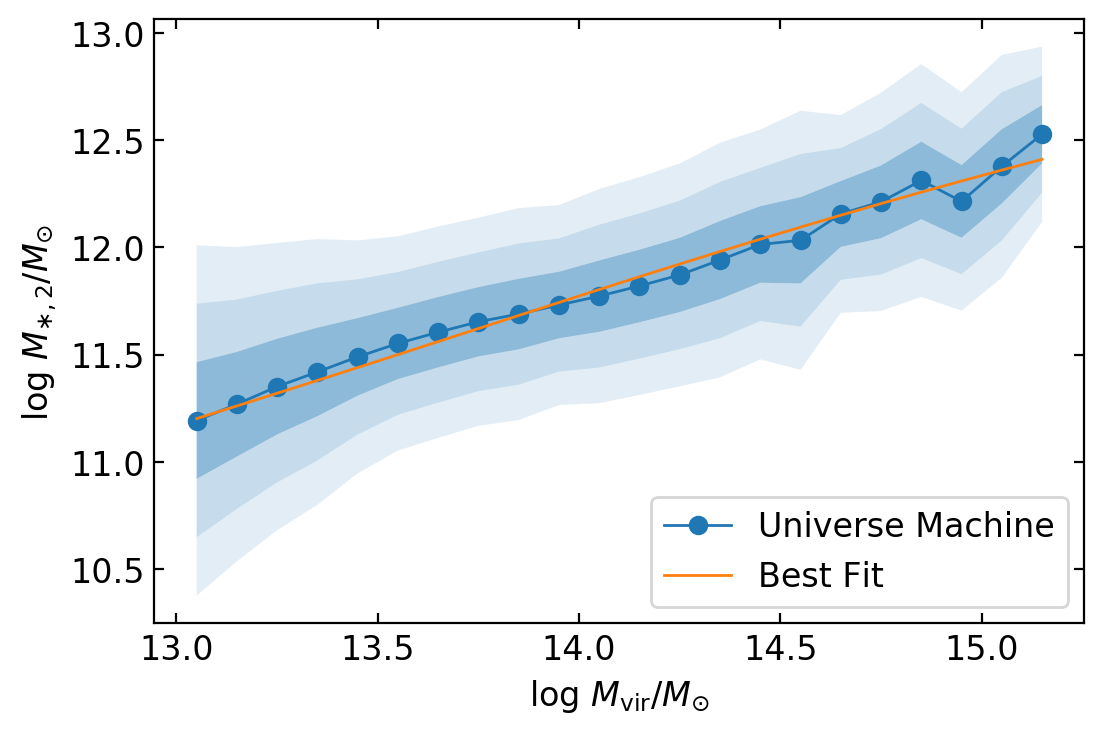

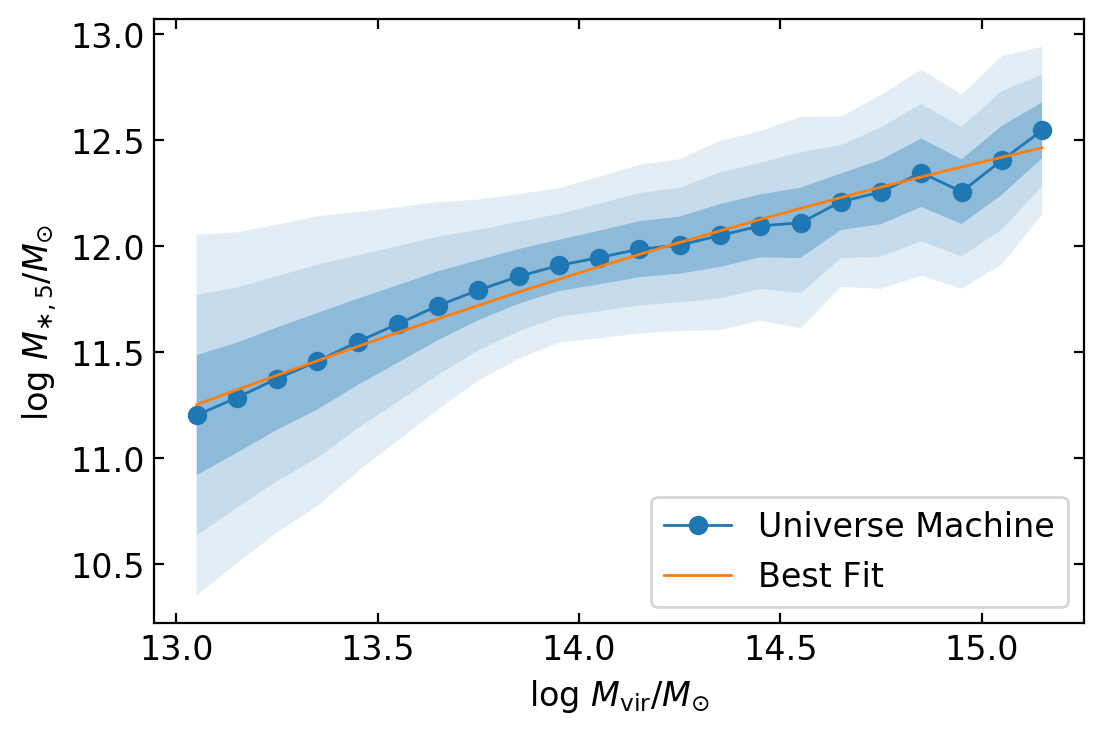

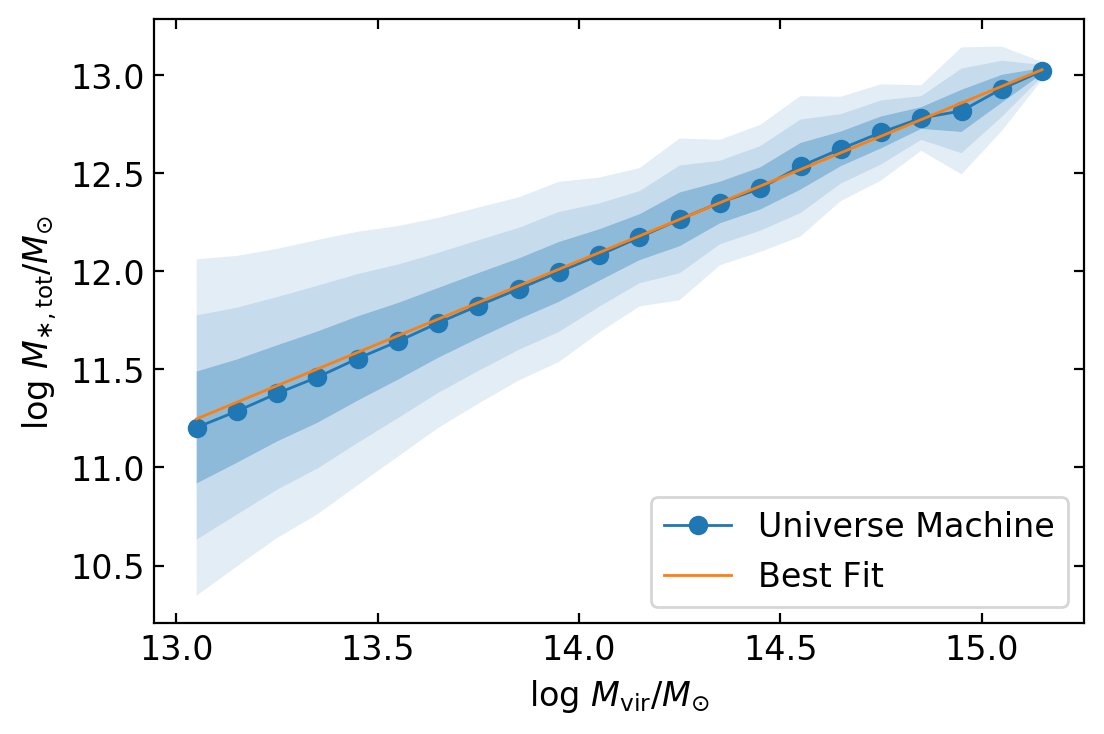

In [35]:
for key in data_halo_cut_obs.keys():#data_halo_cut.keys():
    p.sm_hm.sm_at_fixed_hm(data_halo_cut_obs[key]["data"], key, fit=data_halo_cut_obs[key]["fit"])

# Intro Plot

Intro everything by showing the SM-HM plot + some of the scatter plots (including lit values)

[14726, 9279, 5597, 3294, 1822, 974, 469, 203, 92, 27, 6]
[0.40275121 0.41032545 0.40772982 0.40433667 0.38916627 0.37131122 0.39997981 0.38307743 0.44575701 0.2566552  0.17741879]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[0.2876041  0.27275839 0.25545275 0.23937966 0.22285855 0.21278629 0.2131313  0.2220204  0.17075308 0.20168416 0.17307143]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[0.18656044 0.15889338 0.13250132 0.11267836 0.09286474 0.0768382  0.07046598 0.05538341 0.04502597 0.04462771 0.02357088]


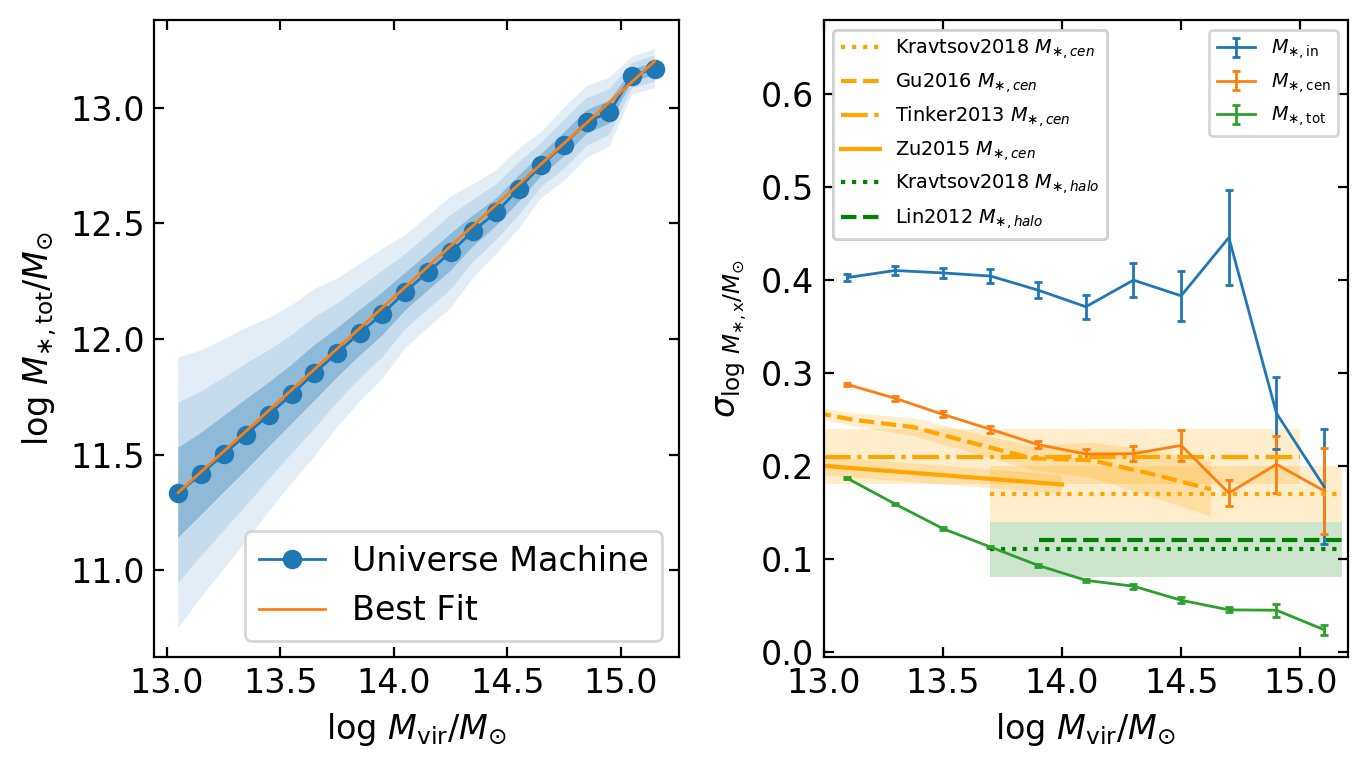

In [16]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7, 4)
p.sm_hm.sm_at_fixed_hm(data_halo_cut["tot"]["data"], "tot", fit=data_halo_cut["tot"]["fit"], ax=axes[0])
p.scatter.in_sm_at_fixed_hm_incl_lit(data_halo_cut, ax=axes[1])
plt.tight_layout()

# Scatter for various definitions of stellar mass

[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[11, 27, 62, 149, 353, 839, 1997, 4851, 11385]
[10, 27, 62, 150, 359, 833, 2048, 4807, 11420]
[12, 27, 60, 147, 350, 862, 2023, 4768, 11602]
[10, 27, 62, 150, 354, 831, 2053, 4811, 11482]
[10, 27, 63, 149, 359, 852, 2026, 4816, 11559]


(0.0, 0.4610784720786142)

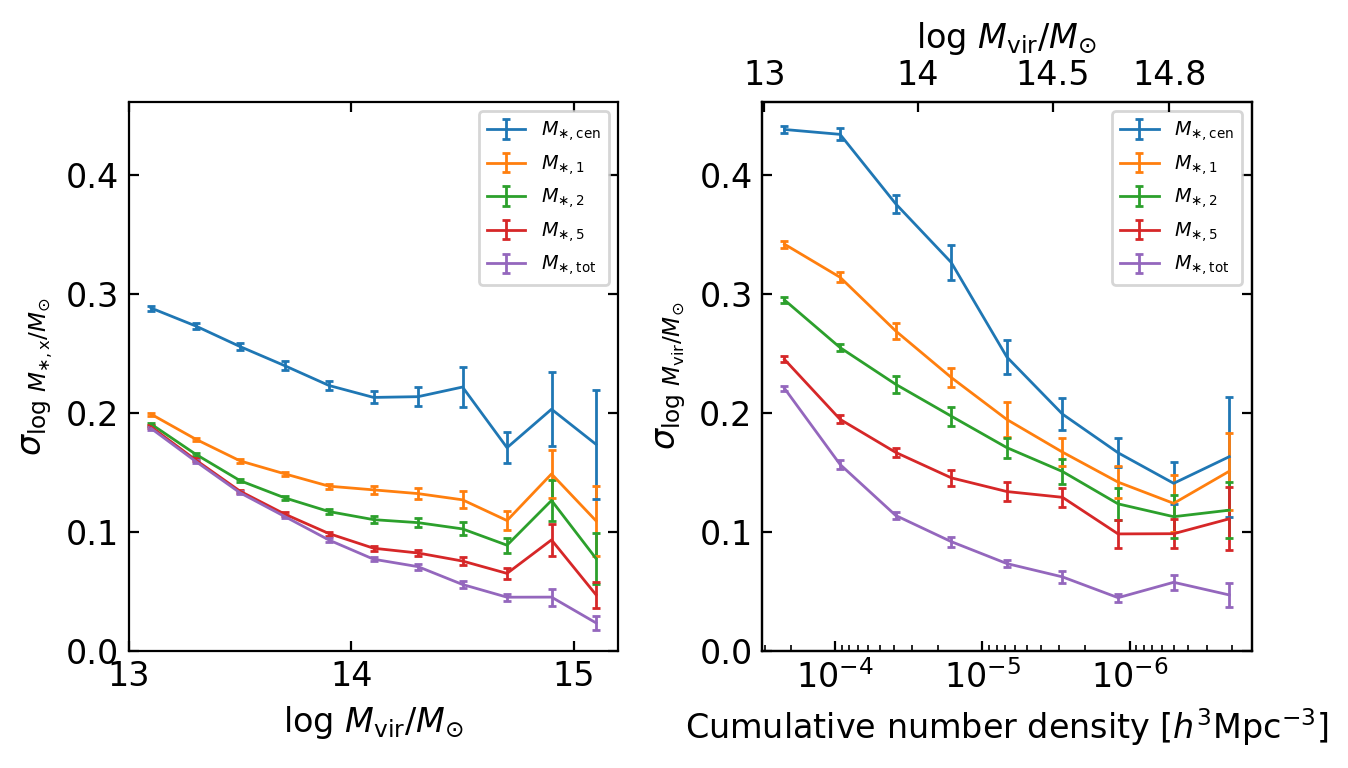

In [20]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7, 4)
p.scatter.in_sm_at_fixed_hm(data_halo_cut, ax=axes[0])
p.scatter.in_hm_at_fixed_number_density(data_stellar_cut, ax=axes[1])
plt.tight_layout()
axes[0].set_ylim(axes[1].get_ylim())

# Stellar mass function for various SMs and vs HSC etc


In [ ]:
assert fits.density_at_mass(data_stellar_cut, "cen", fits.mass_at_density(data_stellar_cut, "cen", 1e2)) == 1e2

In [ ]:
_, ax = plt.subplots()
for key in data_stellar_cut.keys():
    smf_data = data_stellar_cut[key]["smf"]
    ax.plot(smf_data[0], smf_data[1], label=key)
ax.set_yscale("log")
ax.legend()

In [ ]:
_, ax = plt.subplots()
for key in data_stellar_cut.keys():
    smf_data = data_stellar_cut[key]["smf"]
    ax.plot(smf_data[0], smf_data[1], label=key)
ax.set_yscale("log")
ax.legend()

### Comparison with HSC etc

In [ ]:
hsc_smf_file_m10 = "/home/christopher/research/hsc_um2/data/s16a_massive_fastlane_logm10_smf_default.fits"
hsc_smf_file_m100 = "/home/christopher/research/hsc_um2/data/s16a_massive_fastlane_logm100_smf_default.fits"

m10_smf = astropy.io.fits.open(hsc_smf_file_m10)[1].data
m100_smf = astropy.io.fits.open(hsc_smf_file_m100)[1].data

In [ ]:
print(m10_smf.dtype)
print(m10_smf)

In [ ]:
def plot_sim_smf(stellar_masses, ax, label):

    nonzero_stellar_masses = np.log10(stellar_masses[stellar_masses != 0])
    print("Dropped {} galaxies with mass of 0".format(len(stellar_masses) - len(nonzero_stellar_masses)))

    sim_volume = 400**3 # https://redwoodforest.slack.com/archives/C5W6EQCAU/p1513187949000425 SMDPL
    num_bins = 30
    x, y, err = smf.compute_smf(
        nonzero_stellar_masses, sim_volume, num_bins, 
        np.min(nonzero_stellar_masses), np.max(nonzero_stellar_masses),
    )
    ax.errorbar(x, y, yerr = err, label=label)


fig, ax = plt.subplots()
ax.errorbar(m10_smf["logm_mean"], m10_smf["smf"], yerr = m10_smf["smf_err"], label="HSC m10")
ax.errorbar(m100_smf["logm_mean"], m100_smf["smf"], yerr = m100_smf["smf_err"], label="HSC m100")
plot_sim_smf(centrals["sm"], ax, "universe machine insitu centrals")
plot_sim_smf(centrals["sm"] + centrals["icl"], ax, "all mass cents")
plot_sim_smf(np.append(centrals["sm"] + centrals["icl"], satellites["sm"] + satellites["icl"]), ax, "all mass cents and sats")
ax.legend()
ax.set(
    yscale="log",
    xlim=[11, 12.4],
)
fig.set_size_inches(18.5, 10.5)

# Richness as an estimator

What about richness? Does that have a relation with scatter at fixed halo mass

## Sanity check RMF

In [ ]:
fits.density_at_richness(data_stellar_cut, "cen", fits.richness_at_density(data_stellar_cut, "cen", 2e-4))

In [ ]:
#p.scatter.in_richness_at_fixed_hm(data_halo_cut)
#p.scatter.in_hm_at_fixed_richness_number_density(data_stellar_cut)

_, ax = plt.subplots()
rmf_data = data_stellar_cut["cen"]["rmf"]
ax.plot(rmf_data[0], rmf_data[1], label="stellar cut")
rmf_data = data_halo_cut["cen"]["rmf"]
ax.plot(rmf_data[0], rmf_data[1], label="halo cut")
ax.set_yscale("log")
ax.legend()

In [ ]:
r = data_stellar_cut["cen"]["richness"]

ex = r[r["richness"] == 2]
#plt.hist(r, bins=int(np.max(r["richness"])))
#plt.yscale("log")
plt.hist(np.log10(ex["m"]))

## Richness plots


In [34]:
for ds in [data_stellar_cut, data_stellar_cut_specz, data_stellar_cut_photoz]:
    print(len(ds["tot"]["data_cut"]))
    
for ds in [data_stellar_cut, data_stellar_cut_specz, data_stellar_cut_photoz]:
    print(len(ds["cen"]["data_cut"]))

23616
24704
25750
37505
36126
35428


In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7, 4)
fig.subplots_adjust(wspace=0.28)
p.scatter.in_hm_at_fixed_richness_number_density(richness, axes[0])
p.scatter.in_hm_at_fixed_number_density_incl_richness(data_stellar_cut_obs, richness, axes[1])